## Recommendation Engine of Active Boomers

This tutorial is developed for rebuilding the recommendation engine with Collaborative filtering for [Active Boomers](https://irisw0219.github.io/Active-Boomers-User-Guide/) the workout app. [Collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering) is a family of algorithms where there are multiple ways to find similar users or items and multiple ways to calculate rating based on ratings of similar users. 

Most websites like Amazon, YouTube, and Netflix use collaborative filtering as a part of their sophisticated recommendation systems. You can use this technique to build recommenders that give suggestions to a user on the basis of the likes and dislikes of similar users.

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import pymysql
import random

%matplotlib inline

## Connect to the database 
Using `pymysql` package.

In [2]:
connection = pymysql.connect(
    host='db1.crcnvu3pnfow.ap-southeast-2.rds.amazonaws.com',
    port=int(3306),
    user="admin",
    passwd="abcd1234", # confidential!!
    db="b8_db",
    charset='utf8mb4')


## Make SQL queries to load data
All we need for running this algorithm is `rating` data from the db server.
But we will also have a look at the `item` data just to get an idea of what our business is about...

In [3]:
sql_select_Query = pd.read_sql_query("select * from b8_db.popularity_review",connection)

In [4]:
# read sql query into pandas df
rating = pd.DataFrame(sql_select_Query, columns=['review_id','user_id','activity_id','review_rating'])
rating = rating[['activity_id','user_id','review_rating']]
rating.columns = ['item','user','rating']
rating.head()

,item,user,rating
0,5,2,1
1,10,2,-1
2,8,2,1
3,10,6,1
4,8,6,1


We have fetched 105 entries of rating data this time.

In [5]:
rating.shape

(105, 3)

Most ratings are positive given the mean value of the ratings

In [6]:
rating.describe()

,item,user,rating
count,105.000000,105.000000,105.000000
mean,33.485714,49.847619,0.885714
std,23.441053,45.299597,0.466457
min,1.000000,1.000000,-1.000000
25%,8.000000,9.000000,1.000000
50%,39.000000,52.000000,1.000000
75%,50.000000,87.000000,1.000000
max,68.000000,137.000000,1.000000


In [7]:
# Item names associated with the id's
sql_select_Query = pd.read_sql_query("select activity_id, activity_name from b8_db.physical_activity",connection)
item = pd.DataFrame(sql_select_Query, columns=['activity_id',
                                             'activity_name'])
item.columns = ['item_id','item_name']
item.head(10)

,item_id,item_name
0,1,Fast walk
1,2,Easy dance exercises
2,3,ABS HIIT workout
3,4,Cycling
4,5,Pool workout
5,6,Water aerobic
6,7,Badminton
7,8,Tennis
8,9,Shoulder rotation
9,10,Shoulder raise


In [8]:
item.shape

(68, 2)

## Collaborative Filtering Algorithm
The model we are going to build is a rather simple one, which only takes three variables:
1. item id
2. user id
3. rating


To build a system that can automatically recommend items to users based on the preferences of other users, the first step is to find similar users or items via **similarity computation**. The second step is to predict the ratings of the items that are not yet rated by a user.

Similarity computation between items or users is an important part of this approach. Multiple measures are used for this including:
1. Pearson correlation (or centered consine) and 
2. vector cosine based similarity 


The Pearson correlation similarity of two users x, y is defined as

![pearson.svg](pearson.svg)


This method takes into account :
1. the missing ratings (and has it treated as average)
2. tough raters and easy raters (some would tend to give mostly negative ratings while others positive)

In [9]:
import pandas as pd
from surprise import Dataset
from surprise import Reader

In [10]:
reader = Reader(rating_scale=(-1, 1))
data = Dataset.load_from_df(rating[["user", "item", "rating"]], reader)

There are two approaches to do collaborative filtering:
1. User-user
2. Item-item

In fact, item-based collaborative filtering was [developed by Amazon](https://www.cs.umd.edu/~samir/498/Amazon-Recommendations.pdf). In a system where there are more users than items, item-based filtering is faster and more stable than user-based. It is effective because usually, the average rating received by an item doesn’t change as quickly as the average rating given by a user to different items. It’s also known to perform better than the user-based approach when the ratings matrix is sparse.


Since number of items in our app server was currently under 100 while the number of users > 100, an item-to-item collaborative filtering seems more suitable for us here, so we set `user_based` to False in the below parameters. (And we will try and make sense of that by tuning the algorithm parameters later on.)

### K-Nearest Neighbours
The algorithm Centered k-NN we are going to use here is available in `Surprise` as `KNNWithMeans`.

In [11]:
# recommender.py
from surprise import KNNWithMeans

# To use item-based cosine similarity
sim_options = {
    "name": "pearson",
    "user_based": False,  # Compute  similarities between items
}
algo = KNNWithMeans(sim_options=sim_options)

In [12]:
trainingSet = data.build_full_trainset()
algo.fit(trainingSet)

Computing the pearson similarity matrix...
Done computing similarity matrix.


### Example: making predictions for user 1-3 using the trained model

In [13]:
users = [1,2,3]
start = 1
end = 11

for user in users:
    print(f"\nPredicted rating on item{start}-{end-1} for user{user}" )

    for i in range(start,end):
        prediction = algo.predict(user, i)
        print("item",i,":",prediction.est)


Predicted rating on item1-10 for user1
item 1 : 1
item 2 : 1
item 3 : 1
item 4 : 1
item 5 : 1
item 6 : 0.8857142857142857
item 7 : 0.8857142857142857
item 8 : 1
item 9 : 0.8857142857142857
item 10 : -0.5

Predicted rating on item1-10 for user2
item 1 : 1
item 2 : 1
item 3 : 1
item 4 : 1
item 5 : 1
item 6 : 0.8857142857142857
item 7 : 0.8857142857142857
item 8 : 1
item 9 : 0.8857142857142857
item 10 : -1

Predicted rating on item1-10 for user3
item 1 : 0.8857142857142857
item 2 : 0.8857142857142857
item 3 : 0.8857142857142857
item 4 : 0.8857142857142857
item 5 : 0.8857142857142857
item 6 : 0.8857142857142857
item 7 : 0.8857142857142857
item 8 : 0.8857142857142857
item 9 : 0.8857142857142857
item 10 : 0.8857142857142857


## From predicted ratings to actual recommendations
The output of the model is a predicted rating (ranging from -1 to 1). But, what are we goint to do with these predictions?

Since our user/item dataset is currently relatively small in size, we are having higher chance of overfitting here. That's why we are going to downplay the effect of these predictions a little, not ruling out the possibility of items with negative predictions being recommended completely. 

So now, based on the predictions, we are going to manually generate a weight for each item. And then we are going to randomly select an item from such weighted list as a recommendation for a given user. This way, even items with low predicted ratings still get to be recommeded (even though the probability of that is also ralatively lower given the lower weights).

In [14]:
def generate_weights(user,item_list,algo):
    """generates a list of items based on their weights"""
    
    # generates predictions
    def rating_pred(user,item_list,algo):
        pred = {}
        for i in item_list:
            prediction = algo.predict(user, i)
            pred[i] = prediction.est
        return pred
    
    # generates weights 
    weighted_list = []
    pred = rating_pred(3,item_list,algo)
    
    for i in pred.keys():
        if pred[i] <0: # if the predicted rating is negative
            weighted_list += [i]
        elif pred[i] <0.9: # if the predicted rating < 0.9
            weighted_list += 2 * [i]
        else: # if pred == 1
            weighted_list += 3 * [i]
    return weighted_list
    

In [15]:
len(item.item_id)

68

In [16]:
weighted_l = generate_weights(3,item.item_id,algo)
len(weighted_l)

136

## Recommendations generated from the weighted list for user 3

### Simulation: Runing 1000 times of recommendations based on the weighted list for user3

In [17]:
freq_D = {}
for i in range(1000):
    item = random.choice(weighted_l)
    if item not in freq_D:
        freq_D[item] = 1
    else:
        freq_D[item] +=1
 
freq_df = pd.DataFrame(freq_D.items(),columns=['item','frequency'])

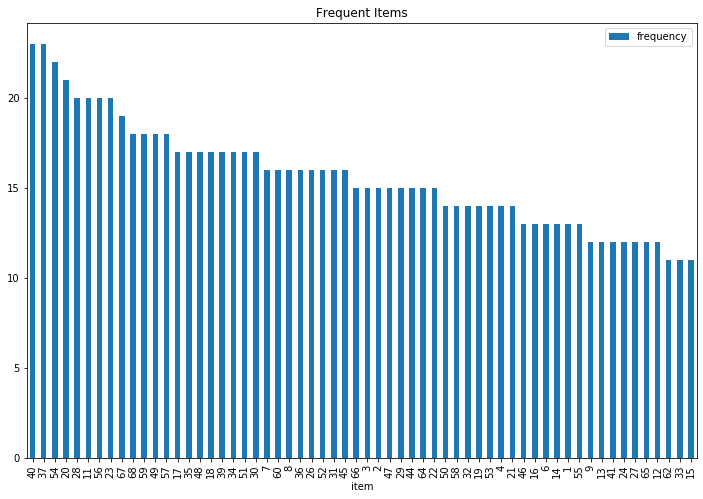

In [18]:
freq_df.sort_values('frequency',ascending=False).set_index('item')[:60].plot(kind='bar',figsize=(12,8),
                                                           title="Frequent Items")
plt.show()

The frequency was indeed not evenly distributed because of the different weights we gave to each item based on the predicted ratings of the algorithm.

### Tuning the Algorithm Parameters
The result suggests that the algorithm works best if you go with those parameters:
{'sim_options': {'name': 'pearson', 'min_support': 3, 'user_based': False}}

In [19]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise.model_selection import GridSearchCV

sim_options = {
    "name": ["pearson", "cosine"],
    "min_support": [3, 4, 5],
    "user_based": [False, True],
}

param_grid = {"sim_options": sim_options}

gs = GridSearchCV(KNNWithMeans, param_grid, measures=["rmse", "mae"], cv=3)
gs.fit(data)

print(gs.best_score["rmse"])
print(gs.best_params["rmse"])

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

## How about the cold start problem?
Finally, we would like to take a moment to think about the cold start problem, which happens when new users or new items arrive in the dataset. Classic recommender systems like collaborative filtering assumes that each user or item has some ratings so that we can infer ratings of similar users/items even if those ratings are unavailable. 

However, for new users/items, this becomes hard when a user has no rating data associated to them. Same problem with out dataset here. However the algorithm seems to have worked just fine... It must have its own ways (maybe by taking a subset of items/users that represents the population) tackling such cold start problem.

### Reference: 
1. [Build a Recommendation Engine With Collaborative Filtering](https://realpython.com/build-recommendation-engine-collaborative-filtering/)
2. [Tackling the Cold Start Problem in Recommender Systems](https://kojinoshiba.com/recsys-cold-start/)